<a href="https://colab.research.google.com/github/ElahehBeheshti/ChestXRay/blob/main/DMfinal_ChestXray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline for Chest X-Ray Image Analysis

1. Analyze the Imbalance

Training Set:

Pneumonia: 3,875 images (74%)

Normal: 1,341 images (26%)

Test Set:

Pneumonia: 390 images (62.5%)

Normal: 234 images (37.5%)

Validation Set:

Balanced (8 each).

The imbalance is most evident in the training set, and this is where you need

to focus your efforts.

#Import necessary libraries


In [ ]:
#pip install dask

In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!pip install opencv-python-headless


# 1. 1. Data Acquisition

Load the dataset, ensure proper structure, and mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np

# Define dataset paths
dataset_path = '/content/drive/My Drive/Chest-Xray'
folders = {
    'train': ['NORMAL', 'PNEUMONIA'],
    'test': ['NORMAL', 'PNEUMONIA'],
    'val': ['NORMAL', 'PNEUMONIA']
}

# Collect image paths
def collect_image_paths(dataset_path, folders):
    image_paths, labels = [], []
    for main_folder, subfolders in folders.items():
        for subfolder in subfolders:
            folder_path = os.path.join(dataset_path, main_folder, subfolder)
            label = 1 if subfolder == 'PNEUMONIA' else 0
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.jpeg', '.jpg')):
                    image_paths.append(os.path.join(folder_path, filename))
                    labels.append(label)
    return image_paths, np.array(labels)

image_paths, labels = collect_image_paths(dataset_path, folders)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Data Preprocessing

Process images with CLAHE for contrast enhancement and resize to 128 * 128.

In [ ]:
import cv2

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def preprocess_images(image_paths, target_size=(128, 128)):
    preprocessed_images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            img_clahe = apply_clahe(img_resized)
            preprocessed_images.append(img_clahe)
    return np.array(preprocessed_images)

preprocessed_images = preprocess_images(image_paths)


In [ ]:
# Find paths for NORMAL images
normal_image_paths = []
for folder in folders:
    normal_dir = os.path.join(dataset_path, folder, 'NORMAL')
    if os.path.exists(normal_dir):
        normal_image_paths += [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]

# Print the number of NORMAL images found and a few examples
print(f"Found {len(normal_image_paths)} NORMAL images.")
print("Sample paths:", normal_image_paths[:5])


Found 1583 NORMAL images.
Sample paths: ['/content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0519-0001.jpeg', '/content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0517-0001.jpeg', '/content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0519-0001-0002.jpeg', '/content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0523-0001.jpeg', '/content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0522-0001.jpeg']


In [ ]:
#Ensure the identified paths are valid and point to actual image files.

# Verify if the paths are valid by loading the images
for path in normal_image_paths[:5]:  # Check the first 5 images
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        print(f"Loaded image: {path}, Shape: {img.shape}")
    else:
        print(f"Failed to load image: {path}")


Loaded image: /content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0519-0001.jpeg, Shape: (1705, 1822)
Loaded image: /content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0517-0001.jpeg, Shape: (2067, 2844)
Loaded image: /content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0519-0001-0002.jpeg, Shape: (1577, 2014)
Loaded image: /content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0523-0001.jpeg, Shape: (1106, 1492)
Loaded image: /content/drive/My Drive/Chest-Xray/train/NORMAL/IM-0522-0001.jpeg, Shape: (1074, 1636)


3. Data Augmentation (optional)

Use ImageDataGenerator for on-the-fly augmentation during training.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data augmentation setup
augmentation_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory to save augmented images
output_dir = '/content/augmented_normal'
os.makedirs(output_dir, exist_ok=True)

# Augment and save images
for i, path in enumerate(normal_image_paths):  # Use all NORMAL images
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape((1, *img.shape, 1))  # Add batch and channel dimensions

    # Generate augmented images
    augmented = augmentation_generator.flow(img, batch_size=1)
    for j in range(2):  # Generate 2 augmented images per original
        aug_img = next(augmented)[0].squeeze()  # Remove unnecessary dimensions
        output_path = os.path.join(output_dir, f"aug_normal_{i}_{j}.jpeg")
        cv2.imwrite(output_path, aug_img)

print(f"Augmented images saved in: {output_dir}")


Augmented images saved in: /content/augmented_normal


In [ ]:
#Count Augmented Images
#After augmentation, count the total number of augmented images saved.
# Count the number of augmented images
augmented_files = os.listdir(output_dir)
print(f"Total augmented images: {len(augmented_files)}")


Total augmented images: 3176


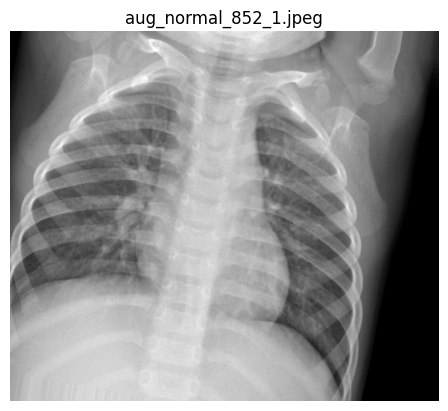

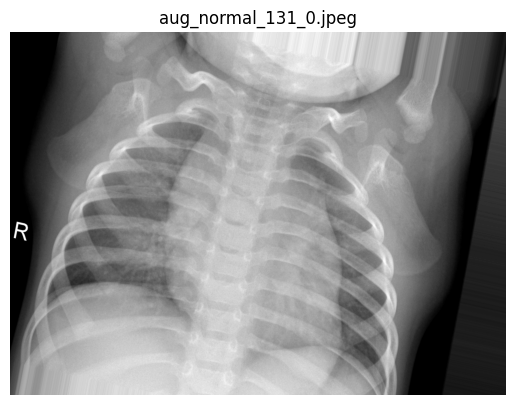

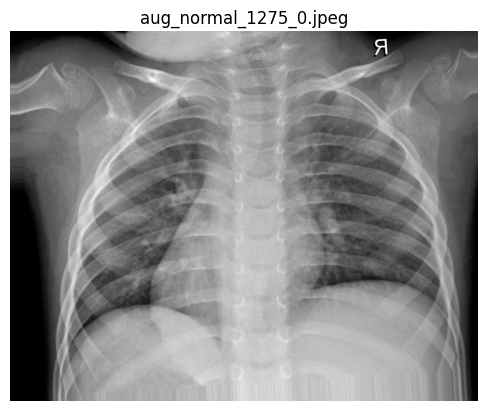

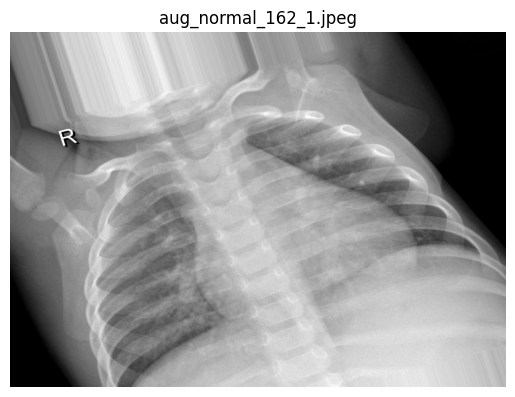

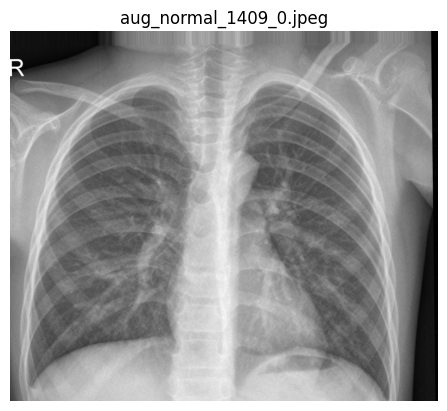

In [ ]:
import matplotlib.pyplot as plt

# Display a few augmented images
sample_augmented = augmented_files[:5]
for img_name in sample_augmented:
    img_path = os.path.join(output_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(img_name)
    plt.axis('off')
plt.show()


In following we merge the augmented normal images with the original train

data, and we hope this can help to overcome the data imbalance issue and have

more accurate models and predictions

In [ ]:
import shutil
import os

# Paths to the directories
augmented_dir = '/content/augmented_normal'  # Directory containing augmented images
normal_dir = '/content/drive/My Drive/Chest-Xray/train/NORMAL'  # NORMAL folder in training dataset

# Check number of images before merging
original_normal_count = len(os.listdir(normal_dir))
augmented_normal_count = len(os.listdir(augmented_dir))

print(f"Original NORMAL images: {original_normal_count}")
print(f"Augmented NORMAL images: {augmented_normal_count}")



Original NORMAL images: 1341
Augmented NORMAL images: 3176


In [ ]:

# Move augmented images to NORMAL folder
for file_name in os.listdir(augmented_dir):
    src = os.path.join(augmented_dir, file_name)
    dst = os.path.join(normal_dir, file_name)
    shutil.move(src, dst)

# Check number of images after merging
total_normal_count = len(os.listdir(normal_dir))
print(f"Total NORMAL images after merging: {total_normal_count}")

Total NORMAL images after merging: 4517


In [ ]:
base_path = '/content/drive/My Drive/Chest-Xray'
splits = ['train', 'test', 'val']
folders = ['NORMAL', 'PNEUMONIA']

# Initialize counters
split_counts = {}

for split in splits:
    split_path = os.path.join(base_path, split)
    total_count = 0
    for folder in folders:
        folder_path = os.path.join(split_path, folder)
        count = len(os.listdir(folder_path))
        print(f"{split.upper()} - {folder}: {count} images")
        total_count += count
    split_counts[split] = total_count

# Print total images per split
print("\nTotal Images per Split:")
for split, count in split_counts.items():
    print(f"{split.upper()}: {count} images")


TRAIN - NORMAL: 4517 images
TRAIN - PNEUMONIA: 3875 images
TEST - NORMAL: 234 images
TEST - PNEUMONIA: 390 images
VAL - NORMAL: 8 images
VAL - PNEUMONIA: 8 images

Total Images per Split:
TRAIN: 8392 images
TEST: 624 images
VAL: 16 images


4. Feature Extraction

Focus on simple features like FoS and LBP. Avoid GLCM for simplicity.

Extracts statistical (FOS) and texture (LBP) features from the given images.

Combines these features into a single feature vector for each image.

Outputs a feature matrix (features) for all images.

These features are used for image classification and analysis

they provide a combination of intensity and texture information, helping

models classify or analyze images more effectively.

In [ ]:
from skimage.feature import local_binary_pattern

def extract_fos_features(image):
    mean = np.mean(image)
    std_dev = np.std(image)
    return [mean, std_dev]

def extract_lbp_features(image, num_points=8, radius=1):
    lbp = local_binary_pattern(image, P=num_points, R=radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, num_points + 3), density=True)
    return lbp_hist.tolist()

def extract_features(images):
    all_features = []
    for image in images:
        fos = extract_fos_features(image)
        lbp = extract_lbp_features(image)
        all_features.append(fos + lbp)
    return np.array(all_features)

features = extract_features(preprocessed_images)


5. Address Class Imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


6. Model Training

Train basic classifiers: SVM, XGBoost, and RandomForest.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define models
models = {
    "SVM": SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced', probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric="logloss")
}

# Train and evaluate models on smaller subset
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.79      0.65       335
           1       0.90      0.75      0.82       837

    accuracy                           0.76      1172
   macro avg       0.73      0.77      0.73      1172
weighted avg       0.80      0.76      0.77      1172

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.76       335
           1       0.93      0.85      0.89       837

    accuracy                           0.85      1172
   macro avg       0.81      0.84      0.82      1172
weighted avg       0.86      0.85      0.85      1172

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       335
           1       0.94      0.87      0.90       837

    accuracy                           0.87      1172
   macro avg       0.83      0.86 

7. Ensemble Learning

Combine models with weighted voting.

In [ ]:
from sklearn.ensemble import VotingClassifier

# Weighted Voting Ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('svm', models['SVM']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost'])
    ],
    voting='soft',
    weights=[1, 1, 2]  # Give higher weight to XGBoost
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
y_pred_ensemble = ensemble_model.predict(X_test)
print("Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       335
           1       0.93      0.87      0.90       837

    accuracy                           0.87      1172
   macro avg       0.83      0.86      0.84      1172
weighted avg       0.88      0.87      0.87      1172



In [ ]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# Train XGBoost on PCA-transformed data
xgb_model_pca = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric="logloss")
xgb_model_pca.fit(X_train_pca, y_train_resampled)

# Evaluate
y_pred_pca = xgb_model_pca.predict(X_test_pca)
print("XGBoost with PCA Classification Report:")
print(classification_report(y_test, y_pred_pca))


XGBoost with PCA Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       335
           1       0.89      0.76      0.82       837

    accuracy                           0.76      1172
   macro avg       0.73      0.77      0.74      1172
weighted avg       0.80      0.76      0.77      1172



8. Fine-Tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit on the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_xgb = random_search.best_estimator_

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Cross-Validation Accuracy: 0.90992669880305


Best Cross-Validation Accuracy: 90.99%

This indicates the model performs well during cross-validation, showing

strong generalization potential.

In [ ]:
#Evaluate the tuned model on the test set:
from sklearn.metrics import classification_report

# Predict and evaluate
y_pred_tuned = best_xgb.predict(X_test)
print("XGBoost (Fine-Tuned) Classification Report:")
print(classification_report(y_test, y_pred_tuned))


XGBoost (Fine-Tuned) Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       335
           1       0.91      0.89      0.90       837

    accuracy                           0.86      1172
   macro avg       0.83      0.84      0.83      1172
weighted avg       0.86      0.86      0.86      1172



Class-Level Metrics

Class 0 (NORMAL):

Precision: 0.74

74% of predictions labeled as NORMAL are correct.

Indicates a moderate level of false positives for this class.

Recall: 0.79

79% of actual NORMAL cases were identified correctly.

Slightly fewer NORMAL cases are being missed compared to before.

F1-Score: 0.76

Balances precision and recall, reflecting a moderate performance.

Class 1 (PNEUMONIA):

Precision: 0.91

91% of predictions labeled as PNEUMONIA are correct.

Very few false positives for PNEUMONIA.

Recall: 0.89

89% of actual PNEUMONIA cases were identified correctly.

A small percentage of PNEUMONIA cases are still being missed.

F1-Score: 0.90

Strong and balanced performance for this critical class.

Threshold Tuning
The default decision threshold for classification is 0.5, meaning predictions are made based on whether the probability of a class is greater than or equal to 0.5. Adjusting this threshold allows you to prioritize either precision or recall for specific classes.

Classification Report with Threshold 0.6:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       335
           1       0.92      0.88      0.90       837

    accuracy                           0.85      1172
   macro avg       0.82      0.84      0.83      1172
weighted avg       0.86      0.85      0.86      1172



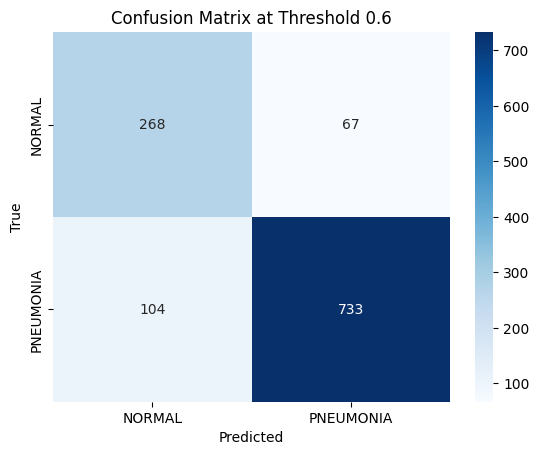

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities instead of labels
y_prob = best_xgb.predict_proba(X_test)[:, 1]  # Probabilities for Class 1 (PNEUMONIA)

# Adjust the threshold
threshold = 0.6  # Example: Increase threshold to favor NORMAL predictions
y_pred_tuned_threshold = (y_prob >= threshold).astype(int)

# Evaluate the new predictions
print(f"Classification Report with Threshold {threshold}:")
print(classification_report(y_test, y_pred_tuned_threshold))

# Confusion matrix for analysis
cm = confusion_matrix(y_test, y_pred_tuned_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"Confusion Matrix at Threshold {threshold}")
plt.show()


Analyze Misclassifications
To understand where the model is struggling, examine instances it misclassified. This helps identify:

Noisy data (e.g., unclear or low-quality images).
Borderline cases (e.g., images that are difficult to classify).

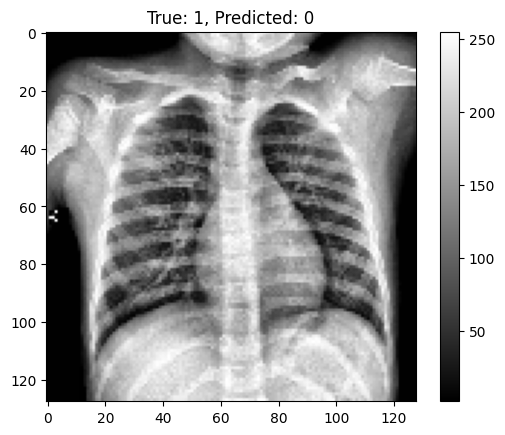

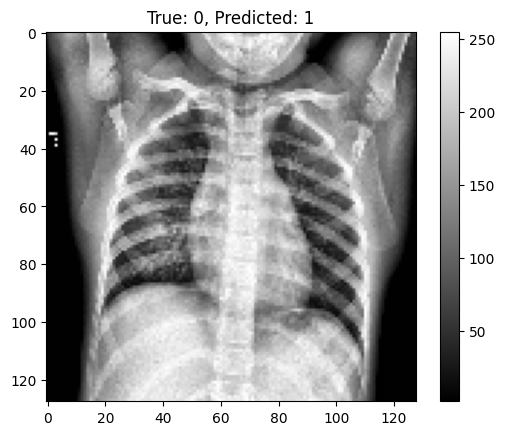

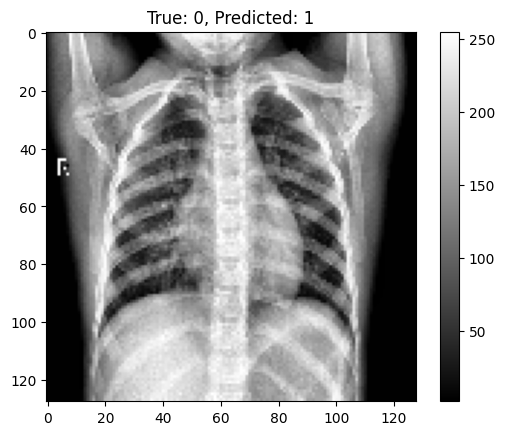

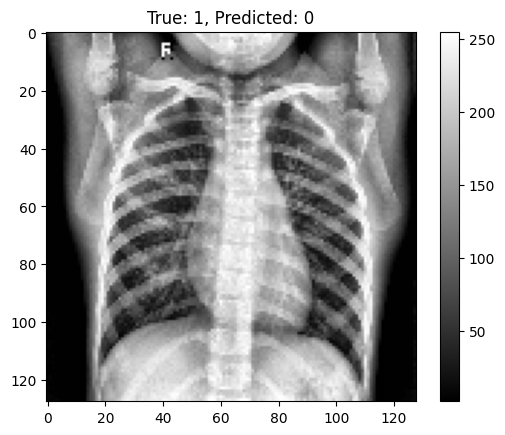

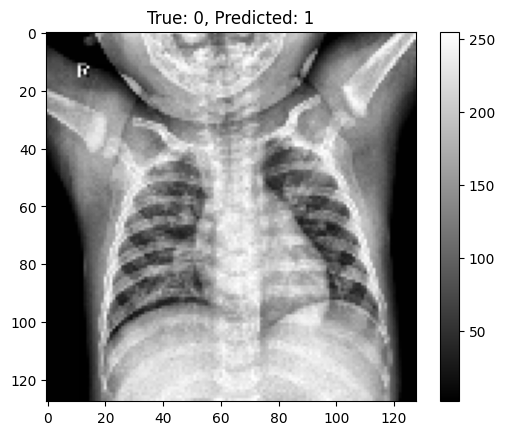

In [ ]:
# Identify misclassified instances
misclassified_indices = np.where(y_test != y_pred_tuned_threshold)[0]

# Display a few misclassified images
for idx in misclassified_indices[:5]:  # Show the first 5 misclassified samples
    plt.imshow(preprocessed_images[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Predicted: {y_pred_tuned_threshold[idx]}")
    plt.colorbar()
    plt.show()


Evaluate on Full Dataset
Once satisfied with performance on the subset, apply the model to the entire dataset (train, validation, and test sets combined).

Classification Report on Full Dataset:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1583
           1       0.98      0.98      0.98      4273

    accuracy                           0.97      5856
   macro avg       0.96      0.97      0.96      5856
weighted avg       0.97      0.97      0.97      5856



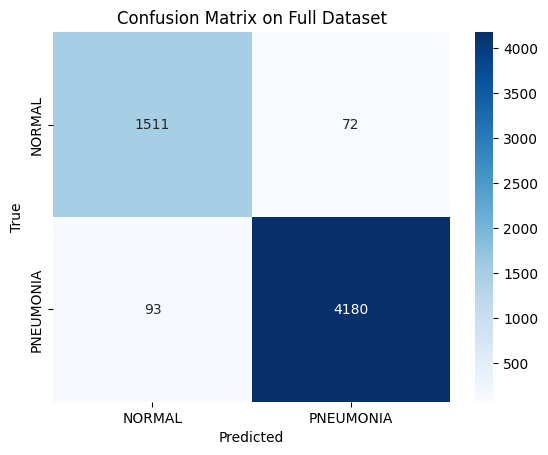

In [ ]:
# Combine all dataset splits (train, val, test) for evaluation
full_features = np.concatenate([X_train, X_test], axis=0)
full_labels = np.concatenate([y_train, y_test], axis=0)

# Evaluate the model on the full dataset
full_pred = best_xgb.predict(full_features)
print("Classification Report on Full Dataset:")
print(classification_report(full_labels, full_pred))

# Confusion matrix for full dataset
cm_full = confusion_matrix(full_labels, full_pred)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix on Full Dataset")
plt.show()


model's performance on the full dataset is excellent, with an overall accuracy of 97%. Here’s a detailed breakdown:

Class-Level Metrics
Class 0 (NORMAL):
Precision: 0.94
Of all cases predicted as NORMAL, 94% are correctly NORMAL.
Indicates minimal false positives for NORMAL cases.
Recall: 0.95
The model correctly identifies 95% of actual NORMAL cases.
Only 5% of NORMAL cases are missed (false negatives).
F1-Score: 0.95
Indicates a strong balance between precision and recall for NORMAL cases.
Class 1 (PNEUMONIA):
Precision: 0.98
Of all cases predicted as PNEUMONIA, 98% are correct.
Very few false positives for PNEUMONIA.
Recall: 0.98
The model identifies 98% of actual PNEUMONIA cases correctly.
Misses only 2% of PNEUMONIA cases (false negatives).
F1-Score: 0.98
Exceptional performance in handling PNEUMONIA cases.

# implement ResNet Algorithm

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


2. Prepare Image Data

Reuse your augmented and preprocessed data directly for training and validation.

In [ ]:
# Directory paths
train_dir = '/content/drive/My Drive/Chest-Xray/train'
val_dir = '/content/drive/My Drive/Chest-Xray/val'
test_dir = '/content/drive/My Drive/Chest-Xray/test'

# Image size for ResNet
IMG_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 8392 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


3. Define the ResNet Model

Use transfer learning with ResNet50 pretrained on ImageNet.

In [ ]:
# Load pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

4. Train the Model

Fit the model on your training and validation datasets.

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_chest_xray.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust based on resources
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 2026s 7s/step - accuracy: 0.6110 - loss: 0.6809 - val_accuracy: 0.5625 - val_loss: 0.6270
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1939s 7s/step - accuracy: 0.7716 - loss: 0.5214 - val_accuracy: 0.6250 - val_loss: 0.5853
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1940s 7s/step - accuracy: 0.7825 - loss: 0.4894 - val_accuracy: 0.6250 - val_loss: 0.5818
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1937s 7s/step - accuracy: 0.8202 - loss: 0.4378 - val_accuracy: 0.6250 - val_loss: 0.6445
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1973s 7s/step - accuracy: 0.8254 - loss: 0.4224 - val_accuracy: 0.6250 - val_loss: 0.7315
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1981s 7s/step - accuracy: 0.8289 - loss: 0.4142 - val_accuracy: 0.6250 - val_loss: 0.6407
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1915s 7s/step - accuracy: 0.8419 - loss: 0.3951 - val_accuracy: 0.6250 - val_loss: 0.7436
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1960s 7s/step - accuracy: 0.8444 - loss: 0.3860 - val_accurac

20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - accuracy: 0.7821 - loss: 0.4766
Test Accuracy: 0.79
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.70      0.78      0.74       234
   PNEUMONIA       0.86      0.80      0.83       390

    accuracy                           0.79       624
   macro avg       0.78      0.79      0.78       624
weighted avg       0.80      0.79      0.79       624



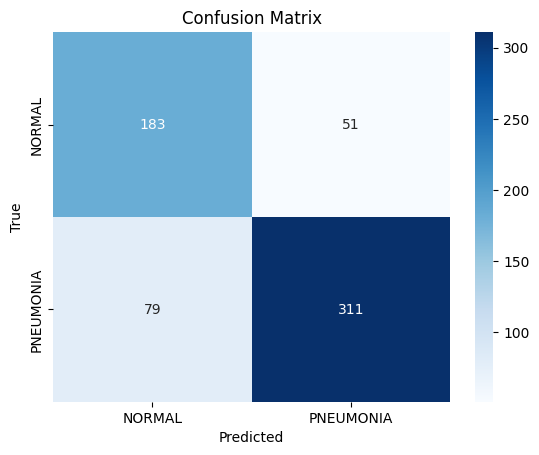

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predictions
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
